$$ y_{in} = F_{act}((Im+n_{in} W_{in}) + bias) $$
$$ Im^* = F_{act}(y_{in} W_{in}^T) + n_{out} $$

$$ Cost = \sqrt{\langle|Im-Im^*|\rangle} + \lambda \langle r \rangle $$

In [1]:
#Dependencies
import os

import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr
#import utils.dirutils as diru

#code to reload
import imp
imp.reload(plu)

#code to limit number of CPUs
maxcpus = 1
#%env CUDA_VISIBLE_DEVICES=0

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [2]:
class aec_model(object):
    
    def __init__(self, params):
      params = self.add_params(params)
      self.params = params
      self.make_dirs()
      self.graph = self.make_graph()
    
    def add_params(self, params):  
        params['compression'] = params['imxlen']*params['imylen']/params['nneurons']
        params['savefolder'] = str('./output/image_output/' + 
                                   '_nonlin1_' + str(params['nonlin1'])+ 
                                   '_nonlin2_' + str(params['nonlin2'])+
                                   '_neurons_'+ str(params['nneurons'])+
                                   '_nin_'+ str(params['noise_x'])+
                                   '_nout_'+ str(params['noise_r'])+
                                   '_bsze_'+ str(params['batchsize'])+
                                   '_epochs_'+ str(params['epochs'])+
                                   '_lrate_'+ str(params['learning_rate'])+
                                   '_lambda_'+ str(params['lambd'])+
                                   '_lnorm_'+ str(params['lambda_norm'])+'/')

        return(params)
        
    def make_dirs(self):
        if not os.path.exists(self.params['savefolder']):
            os.makedirs(self.params['savefolder'])
        else:
            filelist = [f for f in os.listdir(self.params['savefolder'])]
            for f in filelist:
                os.remove(self.params['savefolder']+f)
        
    def make_graph(self):
    
        print('Compressing by',self.params['compression'],'for a total of',self.params['nneurons'],'neurons')

        #setup our graph
        #tf.reset_default_graph()
        mygraph = tf.Graph()
        with mygraph.as_default():

            #input images
            with tf.name_scope('input'):
                self.x = tf.placeholder(tf.float32, shape=[self.params["batchsize"], 
                                                           self.params["imxlen"]*self.params["imylen"]])

            #activation function type
            with tf.name_scope('nonliearities'):
                self.nonlin1 = self.params['nonlin1']
                self.nonlin2  = self.params['nonlin2']

            #noises
            with tf.name_scope('noises'):
                self.noisexsigma = self.params['noise_x']
                self.noisersigma = self.params['noise_r']

            #function to add noise
            with tf.name_scope("add_noise"):
                def add_noise(input_layer, std):
                    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
                    return tf.add(input_layer,noise)

            #weights
            with tf.variable_scope("weights"):

                #per Salimans et al 2016 - Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks parameterize weights as w = g/||v||*v. Now ||w|| = g and we can set g to 1 to enfoce this constraint, and learn the direction of the weights v, while maintaining magnitude of norm 1.
                
                weights_kernel = tf.random_normal([self.params['imxlen']*self.params['imylen'],
                                                         self.params['nneurons']],
                                                        dtype=tf.float32,stddev=1)
                
                self.vin = tf.get_variable('v_in',initializer=weights_kernel)
                self.vout = tf.get_variable('v_out',initializer=tf.transpose(weights_kernel))

                self.win = self.vin/tf.norm(self.vin,ord='euclidean')
                self.wout = self.vout/tf.norm(self.vout,ord='euclidean')               

            #bias
            with tf.variable_scope("in_bias"):
                self.inbias = tf.Variable(tf.random_normal([self.params['nneurons']],
                                                         dtype=tf.float32,
                                                         stddev=1))
            #with tf.variable_scope("out_bias"):
            #    self.outbias = tf.Variable(tf.random_normal([self.params['imxlen']*self.params['imylen']],
            #                                             dtype=tf.float32,
            #                                             stddev=1))

            #lambda
            with tf.name_scope('lambda'):
                self.lambd = self.params['lambd']

            #learning_rate
            with tf.name_scope('learning_rate'):
                self.learning_rate = self.params['learning_rate']

            #nonlienarities
            with tf.name_scope("nonlienarities"):
                #define nonlinearities
                def tanh_fun(bias,arg):
                    return tf.nn.tanh(tf.add(arg,bias)) 
                def sigmoid_fun(bias,arg):
                    return tf.nn.sigmoid(tf.add(arg,bias)) 
                def relu_fun(bias,arg):
                    return tf.nn.relu(tf.add(arg,bias)) 
                def no_fun(bias,arg):
                    return arg

            #with tf.name_scope("weight_normalization"):
            #    #weight normalization
            #    self.win = self.win/tf.reduce_mean(tf.abs(self.win))
            #    self.wout = self.wout/tf.reduce_mean(tf.abs(self.wout))

            #encoding part of model
            with tf.name_scope("encoding"):
                #calculate input
                linearin = tf.add(tf.matmul(add_noise(self.x,self.params['noise_x']),self.win),self.inbias) #add noise to input, and multiply by weights
                self.yin = tf.case({tf.equal(self.nonlin1,'tanh'): (lambda: tanh_fun(self.inbias,linearin)),
                               tf.equal(self.nonlin1,'sigmoid'): (lambda: sigmoid_fun(self.inbias,linearin)),
                               tf.equal(self.nonlin1,'relu'): (lambda: relu_fun(self.inbias,linearin))},
                              default=(lambda: no_fun(self.inbias,linearin)),
                              exclusive=True)
                self.yin_noised = add_noise(self.yin,self.params['noise_r'])


            #output part of model
            with tf.name_scope("decoding"):
                #calculate output (reconstruction)
                linearout = tf.matmul(self.yin_noised,self.wout) #add noise to inner layer, and multiply by weight  transpose
                #self.xp = tf.case({tf.equal(self.nonlin2,'tanh'): (lambda: tanh_fun(self.outbias,linearout)),
                #                    tf.equal(self.nonlin2,'sigmoid'): (lambda: sigmoid_fun(self.outbias,linearout)),
                #                    tf.equal(self.nonlin2,'relu'): (lambda: relu_fun(self.outbias,linearout))},
                #                    default=(lambda: no_fun(self.outbias,linearout)),
                #                  exclusive=True, name='output_nonlienarity')
                
                self.xp = linearout

            #calculate cost
            with tf.name_scope("cost_function"):
                #non-noramlized cost
                #self.cost = tf.sqrt(tf.reduce_mean(tf.square(self.x-self.xp))) + tf.reduce_mean(tf.abs(self.yin*self.lambd))
                normx = self.x #- tf.reduce_min(self.x,axis=0)
                normxp = self.xp #- tf.reduce_min(self.xp, axis=0)
                activation = tf.norm(self.yin,ord=self.params['lambda_norm'],axis=0)
                self.cost = tf.reduce_mean(tf.norm(normx-normxp,ord=1) + (self.lambd * activation))
                                     
            #train our model
            with tf.name_scope("training_step"):
                self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
                #self.train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.cost)

            # create a summary for our cost, im, reconstruction, & weights
            with tf.name_scope('cost_viz'):
                tf.summary.scalar("cost", self.cost)

            with tf.name_scope('image_viz'):    
                x_t = tf.reshape(self.x,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("image", x_t, max_outputs=self.params["batchsize"])

            with tf.name_scope('recon_viz'):
                xp_t = tf.reshape(self.xp,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("recon", xp_t,max_outputs=self.params["batchsize"])

            with tf.name_scope('inweights_viz'):    
                inwin_t = tf.reshape(tf.transpose(self.win),
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("inweights", inwin_t, max_outputs=self.params['nneurons'])
                
            with tf.name_scope('outweights_viz'):    
                outwin_t = tf.reshape(self.win,
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("outweights", outwin_t, max_outputs=self.params['nneurons'])

            # merge all summaries into a single "operation" which we can execute in a session 
            self.summary_op = tf.summary.merge_all()

        return(mygraph)


In [14]:
#make session and train model
def train_model(aec):
    #with tf.device("/gpu:0"):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True #don't allocate the entire GPU's memory
    config.log_device_placement=True #tell me where devices are placed
    with tf.Session(graph = aec.graph, config=config) as sess:

        #initialize vars
        init = tf.global_variables_initializer()
        sess.run(init)

        #summary writer for tensorboard
        writer = tf.summary.FileWriter(aec.params['savefolder'],
                                       graph=tf.get_default_graph())

        #save evolution of system over training
        cost_evolution = []
        wmean_evolution = []

        inweights_evolution = []
        outweights_evolution = []

        images = []
        recons = []
        print('{} hidden neurons, noise_in at {}, noise_out at {}, lambda at {}'.format(aec.params['nneurons'],
                                                                                        aec.params['noise_x'],
                                                                                        aec.params['noise_r'],
                                                                                        aec.params['lambd']))

        print('Training {} iterations in {} epochs... '.format(aec.params['iterations'],
                                                               aec.params['epochs']))
        for epoch in range(aec.params['epochs']):
            #print('Epoch {}: '.format(epoch+1))
            np.random.shuffle(vhimgs.images)
            for ii in range(aec.params['iterations']):

                #reshape our images for feeding to dict
                image = np.reshape(vhimgs.images[ii*aec.params['batchsize']:(1+ii)*aec.params['batchsize'],:,:],
                                   (aec.params['batchsize'],
                                    aec.params['imxlen']*aec.params['imylen'])).astype(np.float32)

                #setup params to send to dictionary
                feeddict = {aec.x: image}

                #run our session
                sess.run(aec.train_step, feed_dict=feeddict)

                #save evolution of params
                objcost, inws = sess.run([aec.cost, aec.win], feed_dict=feeddict)
                cost_evolution.append(objcost)
                wmean_evolution.append(np.mean(np.abs(inws)))

                #print(np.linalg.norm(inws, ord='fro'))

                
                #save detailed parameters 10 times over the total evolution
                if(ii%(int((aec.params['iterations']*aec.params['epochs'])/10))==0):
                    print(str(ii)+', ',end="")
                    #dump our params
                    win, wout, img, recon = sess.run([aec.win, aec.wout, aec.x, aec.xp], feed_dict=feeddict)
                    #save our weights, image, and reconstruction
                    inweights_evolution.append(win)
                    outweights_evolution.append(wout)
                    imshape = [aec.params['batchsize'],
                               aec.params['imxlen'],
                               aec.params['imylen']]
            

                    images.append(np.reshape(img, imshape))
                    recons.append(np.reshape(recon, imshape))

        #summarize final params
        summary, objcost, inws, outws = sess.run([aec.summary_op, aec.cost, aec.win, aec.wout], feed_dict=feeddict)
        cost_evolution.append(objcost)
        wmean_evolution.append(np.mean(inws))
        final_inweights = aec.win
        final_outweights = aec.wout
        writer.add_summary(summary,ii)
        writer.close()

        print('Done!')

        return(cost_evolution,
               wmean_evolution,
               inweights_evolution,
               outweights_evolution,
               images,
               recons,
               final_inweights,
               final_outweights)

In [15]:
#set parameters for parameter sweep
params = {} #make a dictionary

#parameters constant for all
params["patchsize"] = 16
#load in our images
try:
    vhimgs
except NameError:
    vhimgs, nimages = imr.check_n_load_ims(params['patchsize'])
params["nimages"] = nimages
params["imxlen"] = params["patchsize"]
params["imylen"] = params["patchsize"]

#params for sweeping
sweep_neurons = [100]
sweep_nonlin1 = ['relu']
sweep_nonlin2 = ['lienar']
sweep_lambdas = [0]
sweep_lambda_norms = [2]
bsis = [10]
sweep_batch_its = [[bsz,np.int(params['nimages']/bsz)] for bsz in bsis]
sweep_epochs = [1]
sweep_learning_rates = [0.0001] #leave this. it's good.
sweep_noise_xs_rs = [[0,0]]
                 

In [16]:
for neurons in sweep_neurons:
    params['nneurons'] = neurons
    for nonlin1 in sweep_nonlin1:
        params['nonlin1'] = nonlin1
        for nonlin2 in sweep_nonlin2:
            params['nonlin2'] = nonlin2
            for lambd in sweep_lambdas:
                params['lambd'] = lambd
                for lambdn in sweep_lambda_norms:
                    params['lambda_norm'] = lambdn
                    for batchsize, iterations in sweep_batch_its:
                        params['batchsize'] = batchsize
                        params['iterations'] = iterations
                        for epos in sweep_epochs:
                            params['epochs'] = epos
                            for lr in sweep_learning_rates:
                                params['learning_rate'] = lr
                                for xs,rs in sweep_noise_xs_rs:
                                    params['noise_x'] = xs
                                    params['noise_r'] = rs

                                    #make our model
                                    aec = aec_model(params)
                                    #train it'
                                    [cost_evolution,
                                     wmean_evolution,
                                     inweights_evolution,
                                     outweights_evolution,
                                     images,
                                     recons,
                                     final_inweights,
                                     final_outweights] = train_model(aec)

                                    #save model 
                                    plu.save_plots(aec,
                                                   cost_evolution,
                                                   wmean_evolution,
                                                   inweights_evolution,
                                                   outweights_evolution,
                                                   images,
                                                   recons,
                                                   final_inweights,
                                                   final_outweights)
print("*** Parameter Sweep Finished! ***")

Compressing by 2.56 for a total of 100 neurons
100 hidden neurons, noise_in at 0, noise_out at 0, lambda at 0
Training 468582 iterations in 1 epochs... 
1.0
0, 1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


KeyboardInterrupt: 

In [318]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True #don't allocate the entire GPU's memory
config.log_device_placement=True
sess = tf.Session(config=config)
hello = tf.constant('Hello, TensorFlow!')
print(sess.run(hello))

b'Hello, TensorFlow!'


In [7]:
inweights_evolution_r = np.rollaxis(np.reshape(inweights_evolution,
                                                 (len(inweights_evolution),
                                                  aec.params['imxlen'],
                                                  aec.params['imylen'],
                                                    aec.params['nneurons'])),3,1)


plu.display_data_tiled(inweights_evolution_r[-1])

NameError: name 'inweights_evolution' is not defined

1.53176106924
1.82435968332
1.0
1.1910210541


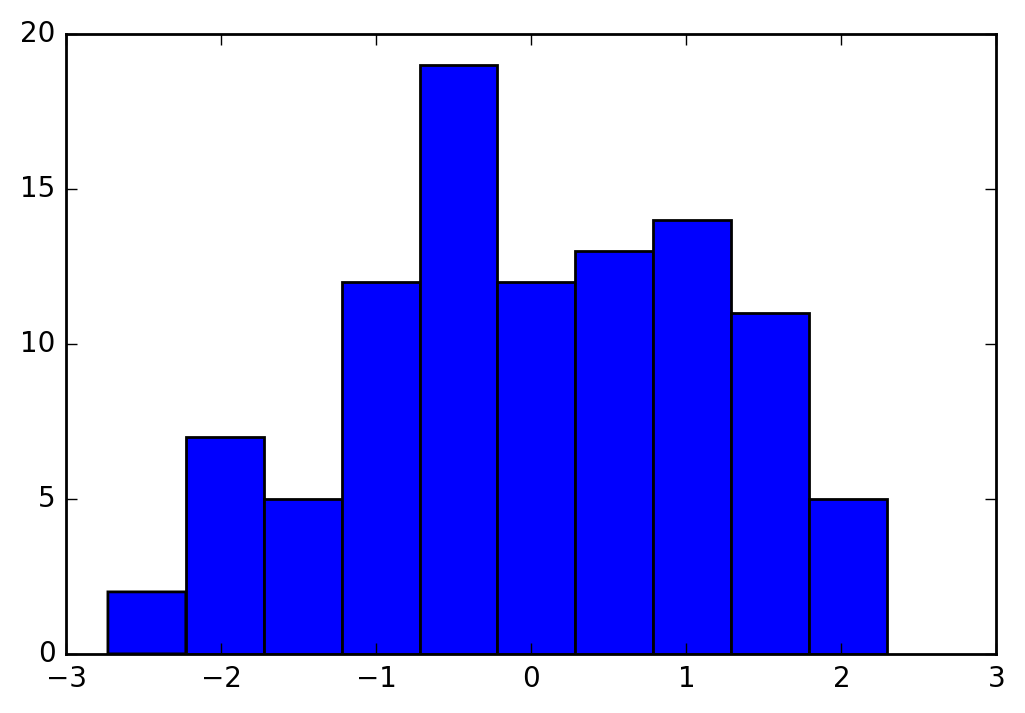

In [74]:
w = np.random.randn(100)*2
#plt.hist(w)

w2 = w/np.mean(np.abs(w))
print(np.mean(np.abs(w)))
print(np.std(w))

plt.hist(w2)
print(np.mean(np.abs(w2)))
print(np.std(w2))
